<a href="https://colab.research.google.com/github/HAPPY365EM/resnet18_cifar10/blob/main/cifar_resnet_cbam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
使用设备: cuda


100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


开始训练...
测试准确率: 51.20%
Epoch 1/100 - Loss: 1.5362 - Accuracy: 51.20%
测试准确率: 63.72%
Epoch 2/100 - Loss: 1.0518 - Accuracy: 63.72%
测试准确率: 71.84%
Epoch 3/100 - Loss: 0.8245 - Accuracy: 71.84%
测试准确率: 74.56%
Epoch 4/100 - Loss: 0.6985 - Accuracy: 74.56%
测试准确率: 75.34%
Epoch 5/100 - Loss: 0.6190 - Accuracy: 75.34%
测试准确率: 78.87%
Epoch 6/100 - Loss: 0.5702 - Accuracy: 78.87%
测试准确率: 67.94%
Epoch 7/100 - Loss: 0.5282 - Accuracy: 67.94%
测试准确率: 73.43%
Epoch 8/100 - Loss: 0.5008 - Accuracy: 73.43%
测试准确率: 83.26%
Epoch 9/100 - Loss: 0.4862 - Accuracy: 83.26%
测试准确率: 80.90%
Epoch 10/100 - Loss: 0.4647 - Accuracy: 80.90%
测试准确率: 79.17%
Epoch 11/100 - Loss: 0.4545 - Accuracy: 79.17%
测试准确率: 79.09%
Epoch 12/100 - Loss: 0.4421 - Accuracy: 79.09%
测试准确率: 81.98%
Epoch 13/100 - Loss: 0.4289 - Accuracy: 81.98%
测试准确率: 79.76%
Epoch 14/100 - Loss: 0.4198 - Accuracy: 79.76%
测试准确率: 81.61%
Epoch 15/100 - Loss: 0.4089 - Accuracy: 81.61%
测试准确率: 82.31%
Epoch 16/100 - Loss: 0.4038 - Accuracy: 82.31%
测试准确率: 80.05%
Epoch 17/10

/tmp/ipython-input-1-2280626119.py:384: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{save_dir}/cbam_learning_curves.png")
/tmp/ipython-input-1-2280626119.py:384: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{save_dir}/cbam_learning_curves.png")
/tmp/ipython-input-1-2280626119.py:384: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{save_dir}/cbam_learning_curves.png")
/tmp/ipython-input-1-2280626119.py:384: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{save_dir}/cbam_learning_curves.png")
/tmp/ipython-input-1-2280626119.py:384: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{save_dir}/cbam_learning_curves.png")
/tmp/ipython-input-1-2280626119.py:384: UserWarning: Glyph 32447 (\N{C

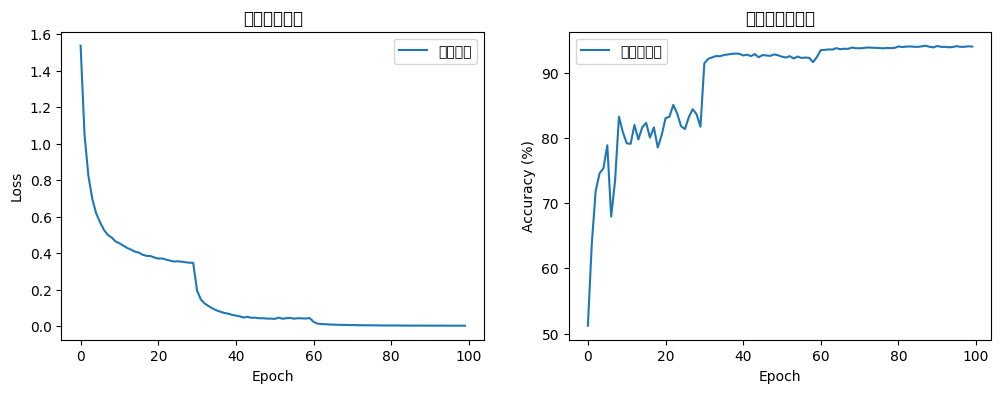

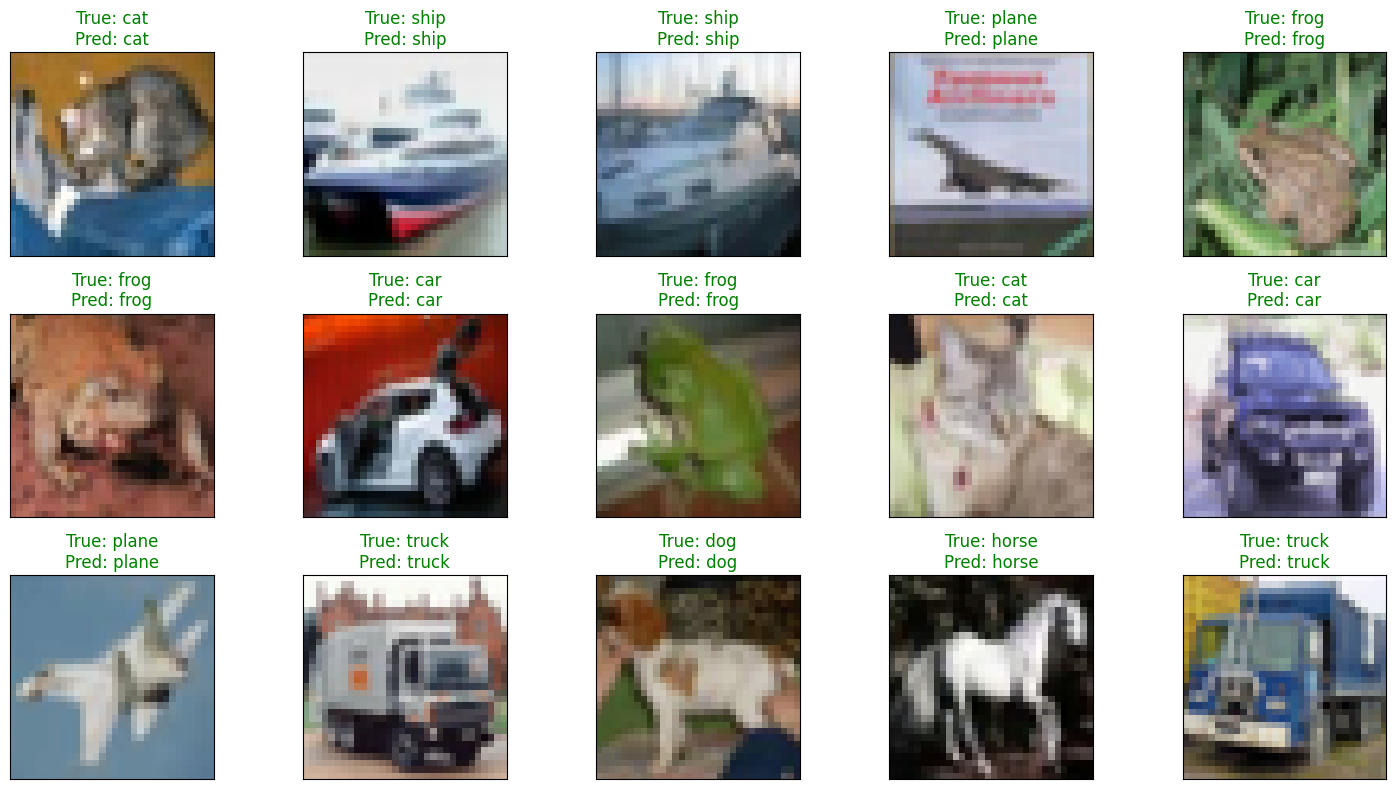

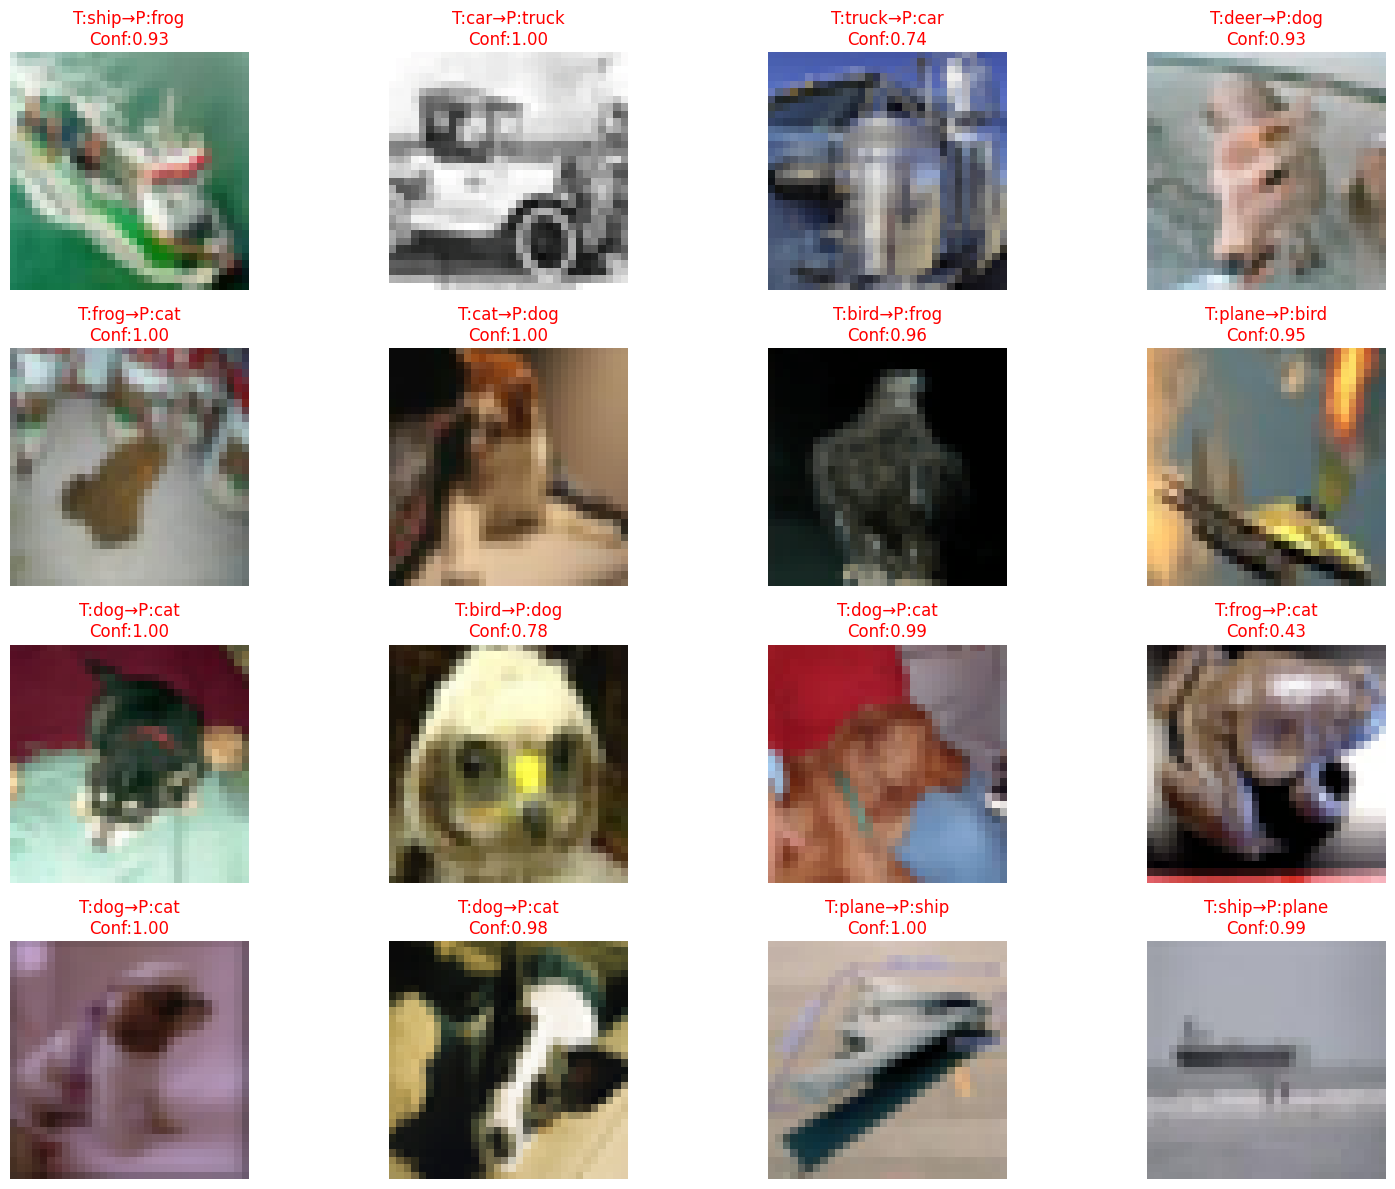

TypeError: expected np.ndarray (got Tensor)

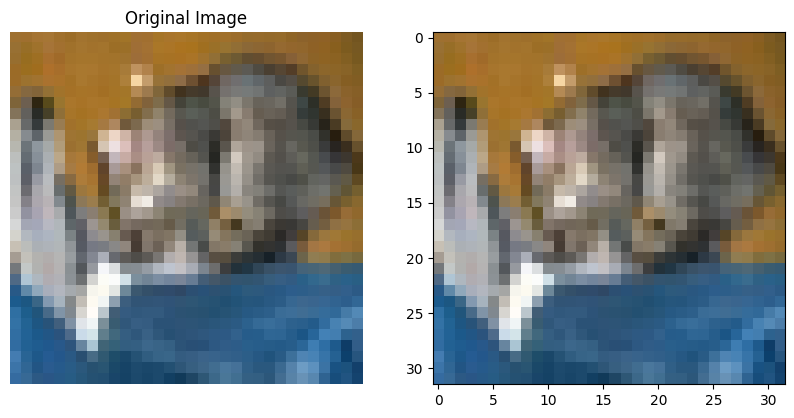

In [ ]:
# ===== 完整独立的CIFAR10训练方案 =====
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from google.colab import drive

# 1. 挂载Google Drive（防止断网丢失数据）
drive.mount('/content/drive')
save_dir = '/content/drive/MyDrive/cifar_resnet_cbam'

# 2. 检查GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 3. 准备数据集
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# 下载CIFAR10数据集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        # 平均池化
        avg_pool = self.avg_pool(x)
        # 重塑为 [batch_size, channels]
        avg_out = avg_pool.view(avg_pool.size(0), avg_pool.size(1))
        avg_out = self.fc(avg_out)

        # 最大池化
        max_pool = self.max_pool(x)
        # 重塑为 [batch_size, channels]
        max_out = max_pool.view(max_pool.size(0), max_pool.size(1))
        max_out = self.fc(max_out)

        # 合并并恢复维度
        out = avg_out + max_out
        # [batch_size, channels] -> [batch_size, channels, 1, 1]
        return out.unsqueeze(-1).unsqueeze(-1)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        concat = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(concat))

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super().__init__()
        self.channel_att = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        out = x * self.channel_att(x)
        out = out * self.spatial_att(out)
        return out

# ===== 修改BasicBlock =====
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, use_cbam=True):  # 添加use_cbam参数
        super(BasicBlock, self).__init__()
        self.use_cbam = use_cbam

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # 添加CBAM模块
        if use_cbam:
            self.cbam = CBAM(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # 添加注意力机制
        if self.use_cbam:
            out = self.cbam(out)

        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, use_cbam=True):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.use_cbam = use_cbam

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, use_cbam=use_cbam)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, use_cbam=use_cbam)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, use_cbam=use_cbam)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, use_cbam=use_cbam)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, use_cbam):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, use_cbam))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.functional.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18(use_cbam=True):  # 独立函数定义
    return ResNet(BasicBlock, [2, 2, 2, 2], use_cbam=use_cbam)

def visualize_predictions(model, test_loader, classes, num_samples=15, save_path=None):
    """
    可视化模型预测结果（正确和错误样本）
    """
    # 反归一化转换器
    inv_normalize = transforms.Normalize(
        mean=[-0.4914/0.247, -0.4822/0.243, -0.4465/0.261],
        std=[1/0.247, 1/0.243, 1/0.261]
    )

    # 获取测试数据
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # GPU处理
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # 创建可视化
    fig = plt.figure(figsize=(15, 8))
    for i in range(num_samples):
        ax = fig.add_subplot(3, 5, i+1, xticks=[], yticks=[])
        # 反归一化并转换通道
        img = inv_normalize(images[i]).cpu().permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        ax.imshow(img)

        # 设置标题颜色
        color = 'green' if predicted[i] == labels[i] else 'red'
        true_label = classes[labels[i]]
        pred_label = classes[predicted[i].item()]
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

def visualize_errors(error_samples, classes, save_path=None):
    """
    可视化错误样本（4×4网格）
    """
    # 创建反归一化转换器（新增）
    inv_normalize = transforms.Normalize(
        mean=[-0.4914/0.247, -0.4822/0.243, -0.4465/0.261],
        std=[1/0.247, 1/0.243, 1/0.261]
    )

    fig, axes = plt.subplots(4, 4, figsize=(16, 12))
    for i, sample in enumerate(error_samples[:16]):
        ax = axes[i//4, i%4]

        # 使用正确的反归一化方法（修改）
        img = inv_normalize(sample['image'])
        img = img.permute(1, 2, 0).numpy()

        ax.imshow(np.clip(img, 0, 1))
        ax.set_title(f"T:{classes[sample['true']]}→P:{classes[sample['pred']]}\nConf:{sample['confidence']:.2f}",
                    color='red')
        ax.axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

# 5. 训练函数
def train_model():
    net = ResNet18().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    train_losses = []
    test_accuracies = []

    print("开始训练...")
    for epoch in range(100):  # 训练100个epoch
        net.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(trainloader))
        scheduler.step()

        # 测试准确率
        accuracy, _ = test_model(net)
        test_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/100 - Loss: {train_losses[-1]:.4f} - Accuracy: {accuracy:.2f}%")

    # 保存模型
    torch.save(net.state_dict(), f"{save_dir}/resnet_cbam_cifar10.pth")

    return net, train_losses, test_accuracies

# 6. 测试函数 (修改后)
def test_model(net=None, save_errors=True):
    if net is None:
        net = ResNet18().to(device)
        net.load_state_dict(torch.load(f"{save_dir}/resnet_cbam_cifar10.pth"))

    net.eval()
    correct = 0
    total = 0
    all_errors = []  # 存储错误样本信息

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 收集错误样本
            if save_errors:
                err_idx = (predicted != labels).nonzero(as_tuple=True)[0]
                for idx in err_idx:
                    # 计算预测置信度
                    confidence = torch.nn.functional.softmax(outputs[idx], 0)[predicted[idx]].item()
                    all_errors.append({
                        'image': images[idx].cpu().clone(),
                        'true': labels[idx].item(),
                        'pred': predicted[idx].item(),
                        'confidence': confidence
                    })

    accuracy = 100 * correct / total
    print(f"测试准确率: {accuracy:.2f}%")

    # 保存错误样本
    if save_errors and all_errors:
        torch.save(all_errors[:20], f"{save_dir}/error_samples.pth")

    return accuracy, all_errors[:20]  # 返回错误样本用于可视化

# 在测试代码中添加特征可视化
def visualize_attention(model, img, save_path=None):
    """可视化注意力热力图（在原始图像上叠加）"""
    model.eval()
    # 获取最后一个CBAM层的空间注意力图
    activations = []
    def hook_fn(module, input, output):
        activations.append(output.detach().cpu())  # 直接获取输出张量

    # 注册钩子
    hook = model.layer4[-1].cbam.spatial_att.register_forward_hook(hook_fn)

    # 前向传播
    with torch.no_grad():
        model(img.unsqueeze(0).to(device))

    # 移除钩子
    hook.remove()

    # 绘制热图
    plt.figure(figsize=(10, 5))

    # 原始图像
    plt.subplot(1, 2, 1)
    # 反归一化
    img_disp = img.cpu().permute(1, 2, 0).numpy()
    img_disp = img_disp * np.array([0.247, 0.243, 0.261]) + np.array([0.4914, 0.4822, 0.4465])
    plt.imshow(np.clip(img_disp, 0, 1))
    plt.title('Original Image')
    plt.axis('off')

    # 修改部分：添加上采样操作
    plt.subplot(1, 2, 2)
    plt.imshow(np.clip(img_disp, 0, 1))

    # 获取注意力图并上采样到32x32
    attention_map = activations[0][0, 0]  # 获取单通道注意力图
    attention_map = torch.from_numpy(attention_map).unsqueeze(0).unsqueeze(0)
    attention_map = nn.functional.interpolate(attention_map, size=32, mode='bilinear', align_corners=False)
    attention_map = attention_map.squeeze().numpy()

    plt.imshow(attention_map, alpha=0.5, cmap='jet')
    plt.title('Attention Heatmap')
    plt.axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# 7. 可视化函数
def visualize_results(train_losses, test_accuracies):
    # 绘制学习曲线
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='训练损失')
    plt.title('训练损失曲线')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='测试准确率')
    plt.title('测试准确率曲线')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.savefig(f"{save_dir}/cbam_learning_curves.png")
    plt.show()

    # 保存最终结果
    final_accuracy = test_accuracies[-1]
    with open(f"{save_dir}/results.txt", "w") as f:
        f.write(f"最终测试准确率: {final_accuracy:.2f}%\n")
        f.write(f"训练时间: {training_time:.2f}分钟\n")

# 8. 主执行流程
start_time = time.time()

# 创建保存目录
!mkdir -p "{save_dir}"

# 训练模型
trained_net, train_losses, test_accuracies = train_model()

# 记录训练时间
training_time = (time.time() - start_time) / 60

# 最终测试（启用错误收集）
final_accuracy, error_samples = test_model(trained_net, save_errors=True)

# 可视化结果
visualize_results(train_losses, test_accuracies)

# ===== 调用可视化函数 =====
# 1. 预测结果可视化
visualize_predictions(
    trained_net, testloader, classes,
    save_path=f"{save_dir}/cbam_prediction_samples.png"
)

# 2. 错误样本可视化
if error_samples:
    visualize_errors(
        error_samples, classes,
        save_path=f"{save_dir}/cbam_error_analysis.png"
    )

# 3. 注意力可视化（选择第一个测试样本）
sample_img = next(iter(testloader))[0][0]  # 获取第一个测试样本
visualize_attention(
    trained_net, sample_img,
   save_path=f"{save_dir}/cbam_attention_heatmap.png"
)

# 下载结果文件
from google.colab import files
files.download(f"{save_dir}/cbam_learning_curves.png")
files.download(f"{save_dir}/results.txt")

print("所有操作已完成！")